to do:
    - spectrum for Jp
    - some files are in the making:
        - Co60 for: Copper Top Ring, Copper Field Shaper, Teflon_Pillar_. PmtTpc, BellPlate
        - U238 for Copper Field Guards,
        - Ra 226 for OuterCryo 
    - plot like Fig.2 here ( https://arxiv.org/pdf/1512.07501.pdf) 
    - why is the rate so high?

In [24]:
print("loading....")
%run 'init.ipynb'
%run 'geometry_checks.ipynb'
%run 'functions.ipynb'

from multiprocessing import Pool
from multiprocessing import Process, Value, Array
print("done!")

loading....
done!


In [25]:
N = 100000000 #events generated in the root stage
m_fv = 4 #tons

#some files are corrupted, therefore we exclude them 

def number_of_events(material):
    N = 100000000
    if material == "SS_OuterCryostat":
        n = {
        'U238' :N-3000 ,
        'Co60' : N, 
        'K40' : N,
        'Cs137' : N,
        'Th228' : 999*100000, 
        'Th232' : N,    
        'U235' : N,
        'Ra226' : N,
        }
    if material == "SS_InnerCryostat":
        n = {
        'U238' :N ,
        'Co60' : N, 
        'K40' : N,
        'Cs137' : N,
        'Th228' : N, 
        'Th232' : N,
        'U235' : N,
        'Ra226' : N,
        }
    if material == "OuterCryostatReflector":
        n = {
        'U238' :N-3000 ,
        'Co60' : N, 
        'K40' : N,
        'Cs137' : N,
        'Th228' : N-1000, 
        'U235' : N,
        'Th232' : N-2000,
        'Ra226' : N,
        }  
    if material == "SS_BellPlate":
        n = {
        'U238' :N ,
        'Co60' : N-2000, 
        'K40' : N,
        'Cs137' : N,
        'Th228' : N, 
        'U235' : N,
        'Th232' : N,
        'Ra226' : N,
        }   
    if material == "SS_BellSideWall":
        n = {
        'U238' :N ,
        'Co60' : 990*100000, 
        'K40' : N,
        'Cs137' : N,
        'Th228' : N, 
        'U235' : N,
        'Th232' : N,
        'Ra226' : N,
        }  
    if material ==  "Teflon_TPC":
        n = {
        'U238' :N ,
        'Co60' : N -1000, 
        'K40' : N,
        'Cs137' : N,
        'Th228' : N, 
        'U235' : N,
        'Th232' : N,
        'Ra226' : N,
        }  
    if material ==  "Copper_FieldShaperRing_":
        n = {
        'U238' :N ,
        'Co60' : N -1000, 
        'K40' : N,
        'Cs137' : N,
        'Th228' : N, 
        'U235' : N,
        'Th232' : N,
        'Ra226' : N,
        }    
    if (  (material == "Teflon_Pillar_") 
                                       | (material == "PmtTpc")          |(material == "SS_AnodeRing")     
                                       |( material =="Teflon_BottomTPC") 
                                       | (material == "Copper_TopRing")  |(material ==  "Copper_TopRing") 
                                       | (material =="Copper_TopRing")   |  (material == "Copper_FieldGuard_") 
                                       | (material == "Copper_BottomPmtPlate")
                                       ):
        n = {
        'U238' :N,
        'Co60' : N, 
        'K40' : N,
        'Cs137' : N,
        'Th228' : N, 
        'U235' : N,
        'Th232' : N,
        'Ra226' : N,
        }  
    
    return n



In [42]:
#apply cuts to the dataframe: single scatter, fv, and evergy ROI. If evergy ROI is empty, extend it to 0-100 and re-normalize.
#assume the spectrum is flat 
def calculate_events(data, isotope):
    events_passing = 0
    ss = single_scatter(data)
    fv_ = fv(ss)
    energy_ = energy(fv_, 1, 12)
    events_passing = len(energy_)
    if events_passing == 0:
        en_enlarged = energy(fv_, 1, 200)
        if len(en_enlarged)!= 0:
            events_passing = (len(en_enlarged)*11)/199
        if len(en_enlarged) == 0:
            events_passing = 2.3
            return events_passing
        else:
            return events_passing
    else:
        return events_passing


In [39]:
#function to read the root file in chuncks 
def get_xyz(rootfile):
    dataframe = []
    for df in read_root(rootfile, "events/events", chunksize=1000000,
                             columns= ["xpri", "ypri", "zpri", "epri", "ns", "X", "Y", "Z", "Ed"],
                             where="ns==1"
                            ):#, unit = "chunks"):
        #print(df.X)
        x_values=[x[0] for x in df.X]
        y_values=[y[0] for y in df.Y]
        z_values=[z[0] for z in df.Z]
        df["X"]=x_values
        df["Y"]=y_values
        df["Z"]=z_values
        dataframe.append(df)
    
    dataframe=pd.concat(dataframe)
    dataframe.columns = ['xp', 'yp', 'zp_uc', "epri", "ns", "X", "Y", "Z_uc", "Ed"] #rename 
    offset = 1488/2
    dataframe['rp'] = np.sqrt(dataframe.xp**2+ dataframe.yp**2)
    dataframe['r2p'] = dataframe.rp*dataframe.rp
    dataframe['R'] = np.sqrt(dataframe.X**2+ dataframe.Y**2)
    dataframe['R2'] = (dataframe.R*dataframe.R)
    dataframe['Z'] = dataframe.Z_uc+offset
    dataframe['zp'] = dataframe.zp_uc+ offset
    return dataframe




In [15]:
#list of components and isotopes available.

components = ["PmtTpc",
             "OuterCryostat_Elongation",
             "OuterCryostatShell", 
             "OuterCryostat_flanges",
             "SS_InnerCryostatShell",
             "SS_InnerCryostatFlanges",
             "SS_InnerCryostat_bottomDome",
             "OuterCryostatReflector",
             "SS_BellPlate",
             "SS_BellSideWall",
             "SS_BellSideWallBottomLip",
             "Teflon_Pillar_",
             "SS_AnodeRing",
             "Teflon_TPC_Sliding",
             "Teflon_TPC_Fixed",
             "Teflon_BottomTPC",
              "Copper_TopRing",
             "Copper_FieldGuard_",
              "Copper_FieldShaperRing_",
              "Copper_BottomPmtPlate"
             ]

isotope_array = ["U238",
                "Co60",
                "K40",
                "Cs137",
                "Th228",
                "U235",
                "Th232",
                "Ra226"
                ]
#nb ra226 avaialble for everythign but the outer cryo, ongoing sim 

In [40]:
#test cell for nSort
"""
materials = [ "Copper_FieldGuard_"]
isotope_array = ["U238",
                "Co60",
                "K40",
                "Cs137",
                "Th228",
                "U235",
                "Th232",
                "Ra226"
                ]

for material in materials:
    print(material)
    for isotope in isotope_array:
        rootfile = '/userdata/arocchetti/rootfiles/' +'output_'+ material + '_' + isotope +'_FINAL' + '.root'
        print(rootfile)
        try:
            data = get_xyz(rootfile)
       
            print(isotope, max(data.R))
        except OSError:
            print(rootfile)
"""

'\nmaterials = [ "Copper_FieldGuard_"]\nisotope_array = ["U238",\n                "Co60",\n                "K40",\n                "Cs137",\n                "Th228",\n                "U235",\n                "Th232",\n                "Ra226"\n                ]\n\nfor material in materials:\n    print(material)\n    for isotope in isotope_array:\n        rootfile = \'/userdata/arocchetti/rootfiles/\' +\'output_\'+ material + \'_\' + isotope +\'_FINAL\' + \'.root\'\n        print(rootfile)\n        try:\n            data = get_xyz(rootfile)\n       \n            print(isotope, max(data.R))\n        except OSError:\n            print(rootfile)\n'

In [44]:
def get_data(isotope, component):
    N = 100000000
    #return the correct root file to load according to the component
    df = pd.DataFrame()
    if component == "OuterCryostatShell":
        DATE = "XENONnT_20191202"
        material = "SS_OuterCryostat" 
        rootfile = '/userdata/arocchetti/rootfiles/' +'output_'+ material + '_' + isotope +'_FINAL' + '.root'
        data = get_xyz(rootfile)
        flange1, flange2, flange3, shell, elongation = divide_outercryo(data)
        fraction_shell, fraction_elong, fraction_flanges = outer_cryo_numbers(N)
        df = shell
        frac = fraction_shell 
    elif component == "OuterCryostat_Elongation":
        DATE = "XENONnT_20191202"
        material = "SS_OuterCryostat"
        rootfile = '/userdata/arocchetti/rootfiles/' +'output_'+ material + '_' + isotope +'_FINAL' + '.root'
        data = get_xyz(rootfile)
        flange1, flange2, flange3, shell, elongation = divide_outercryo(data)
        df = elongation
        fraction_shell, fraction_elong, fraction_flanges = outer_cryo_numbers(N)
        frac = fraction_elong 
    elif component == "OuterCryostat_flanges":
        DATE = "XENONnT_20191202"
        material = "SS_OuterCryostat"
        rootfile = '/userdata/arocchetti/rootfiles/' +'output_'+ material + '_' + isotope +'_FINAL' + '.root'
        data = get_xyz(rootfile)
        flange1, flange2, flange3, shell, elongation = divide_outercryo(data)
        flanges = pd.concat([flange1, flange2, flange3])
        df = flanges
        fraction_shell, fraction_elong, fraction_flanges = outer_cryo_numbers(N)
        frac = fraction_flanges
    elif component == "SS_InnerCryostatShell":
        material = "SS_InnerCryostat" 
        rootfile = '/userdata/arocchetti/rootfiles/' +'output_'+ material + '_' + isotope +'_FINAL' + '.root'
        data = get_xyz(rootfile)
        flange1_in, flange2_in, flange3_in, shell_in, elongation_in = divide_innercryo(data)
        flanges_in = pd.concat([flange1_in, flange2_in, flange3_in])
        fraction_shell, fraction_elong, fraction_flanges = inner_cryo_numbers(N)
        df = shell_in
        frac = fraction_shell
    elif component == "SS_InnerCryostatFlanges":
        material = "SS_InnerCryostat" 
        rootfile = '/userdata/arocchetti/rootfiles/' +'output_'+ material + '_' + isotope +'_FINAL' + '.root'
        data = get_xyz(rootfile)
        flange1_in, flange2_in, flange3_in, shell_in, elongation_in = divide_innercryo(data)
        flanges_in = pd.concat([flange1_in, flange2_in, flange3_in])
        fraction_shell, fraction_elong, fraction_flanges = inner_cryo_numbers(N)
        df = flanges_in
        frac = fraction_flanges
    elif component == "SS_InnerCryostat_bottomDome":
        material = "SS_InnerCryostat" 
        rootfile = '/userdata/arocchetti/rootfiles/' +'output_'+ material + '_' + isotope +'_FINAL' + '.root'
        data = get_xyz(rootfile)
        flange1_in, flange2_in, flange3_in, shell_in, elongation_in = divide_innercryo(data)
        flanges_in = pd.concat([flange1_in, flange2_in, flange3_in])
        fraction_shell, fraction_elong, fraction_flanges = inner_cryo_numbers(N)
        frac = fraction_elong
        df = elongation_in
    elif component == "SS_BellSideWall":
        material = 'SS_BellSideWall'
        rootfile = '/userdata/arocchetti/rootfiles/' +'output_'+ material + '_' + isotope +'_FINAL' + '.root'
        data = get_xyz(rootfile)
        bottomLip, bellWall = divide_bellWall(data)
        fraction_side, fraction_lip = bell_wall_numbers(N)
        frac = fraction_side
        df = bellWall
    elif component == "SS_BellSideWallBottomLip":
        material = 'SS_BellSideWall'
        rootfile = '/userdata/arocchetti/rootfiles/' +'output_'+ material + '_' + isotope +'_FINAL' + '.root'
        data = get_xyz(rootfile)
        bottomLip, bellWall = divide_bellWall(data)
        df = bottomLip 
        fraction_side, fraction_lip = bell_wall_numbers(N)
        frac = fraction_lip
    elif component == "Top_PTFE_Frame":
        material = 'SS_Teflon_TopElectrodesFrame'
        rootfile = '/userdata/arocchetti/rootfiles/' +'output_'+ material + '_' + isotope +'_FINAL' + '.root'
        data = get_xyz(rootfile)
        frac = 1
    elif component ==  "Teflon_TPC_Sliding":
        DATE = "XENONnT_20191202"
        material = "Teflon_TPC"
        rootfile = '/userdata/arocchetti/rootfiles/' +'output_'+ material + '_' + isotope +'_FINAL' + '.root'
        df = get_xyz(rootfile)
        frac = 100
    elif component ==  "Teflon_TPC_Fixed":
        DATE = "XENONnT_20191202"
        material = "Teflon_TPC"
        rootfile = '/userdata/arocchetti/rootfiles/' +'output_'+ material + '_' + isotope +'_FINAL' + '.root'
        df = get_xyz(rootfile)
        frac = 100
    else:
        material = component
        rootfile = '/userdata/arocchetti/rootfiles/' +'output_'+ material + '_' + isotope +'_FINAL' + '.root'
        df = get_xyz(rootfile)
        frac = 100
    return df, frac, material

In [29]:
#data, fr , material = get_data("U238", "SS_InnerCryostatFlanges")
#data.head()
#print(len(data))

In [45]:
def do(component, m_fv): 
    #main function to calculate the rate
    conv = 3.15*1e7 #conversion factor s->y
    rate_array = []
    error_array = []
    i = 0
    flag = 0
    total_str = ""  
    E = 11
    time_array = []
  
    for i in range(0, len(isotope_array)):
        note = " "
        isotope = isotope_array[i]
        data, frac, material = get_data(isotope, component)
        #n = select<<<<_typepri(data, isotope)-------> in case other type pri function 
        N_ = number_of_events(material)
        N = N_[isotope]
        b = select_typepri(isotope) #return the normalization for the isotope. chains
        n =  N*(frac/100)*(1/b) #n_gen * fraction events in that component * chain_factor
        
        n_events = calculate_events(data, isotope)
        #print("---", isotope, n, N, frac, n_events, b )
        p = get_parameters(component)
        mass = p['mass']
        contamination = p[isotope] 
        err = "err_"+isotope
        err = str(err)
        error_cont = p[err]/1000 #mBq->Bq
        if error_cont == 0:
            note = "*"
        else:
            note = " "
        if (contamination == 0):
            rate = 0
            error_rate = 0
            str_ = ( "| no contamination value ")
            alpha = 0
            time = 0

        else:
            contamination = p[isotope]/1000 
            time = n / (mass * contamination)
            #print("----", isotope, time/conv)
            rate = n_events/(time * m_fv ) #*E  #ev/s*kg
            alpha = mass / (m_fv * n) #correct with mass*b/(m_fv*E*N_gen)  ##no energy   
            error_rate = alpha * np.sqrt((n_events * error_cont)**2 + (contamination*np.sqrt(n_events))**2)
            
            if n_events == 2.3: 
                str_ = ("| <%2.2g" %(rate*conv)) + note
                flag = flag +1
            else:
                str_ = ("|(%2.2g +- %2.2g)" %(rate*conv, error_rate*conv))+ note 
            
        rate_array = np.append(rate_array, rate)
        error_array = np.append(error_array, error_rate) 
        total_str = total_str  + str_ 
        
        if time == 0:
            time_array = time_array = np.append(time_array, time)  
        else:
            time_array = time_array = np.append(time_array, time/conv)
        
        i = i+1 
        tot_rate = 0
        tot_error_rate = 0
        if len(rate_array)!=0:
            for i in range(0, len(rate_array)):
                tot_rate = tot_rate + rate_array[i]
                tot_error_rate = tot_error_rate + error_array[i]
                if flag == 0:
                    total_rate_string = ("|(**%2.2g +- %2.2g)" %(tot_rate*conv, tot_error_rate*conv)+ "**|" )
                else:
                    total_rate_string = ("|**<%2.2g " %(tot_rate*conv)+ "**|") 
        else:
            total_rate_string = "|"        
    print("|" + component + total_str + total_rate_string)
    return tot_rate*conv, time_array
    
####################################################################################
do("SS_InnerCryostatFlanges", 4)

|SS_InnerCryostatFlanges| <2.6 |(12 +- 8.4) |(0.15 +- 0.36)*|(0.04 +- 0.098)*|(0.56 +- 1.7) | <0.24 | <0.39 |(5.8 +- 5.8)*|**<22 **|


(21.616559409629115,
 array([0.22352705, 0.04194878, 0.27940881, 1.04312622, 0.04967268,
        2.3707414 , 1.49018031, 0.04346359]))

In [31]:
#Cryostat
m_fv = 4
components = [
             "OuterCryostat_Elongation",
             "OuterCryostatShell", 
             "OuterCryostat_flanges",
             "SS_InnerCryostatShell",
             "SS_InnerCryostatFlanges",
             "SS_InnerCryostat_bottomDome",
             ]

#function to return the rates nicely formatted
def print_results(m_fv):
    total_rate = []
    times = []
    print("^material ^", isotope_array[0], "^", isotope_array[1], "^", isotope_array[2], "^",isotope_array[3], "^", isotope_array[4],"^",
             isotope_array[5], "^",isotope_array[6], "^",isotope_array[7], "^ Tot ^", )
    for component in components:
        tot_rate_per_comp, time = do(component, m_fv)
        total_rate = np.append(total_rate, tot_rate_per_comp)
    print("^Tot.^^^^^^^^^", "%.2g" %(sum(total_rate)), "ev/t*y^")     

print_results(m_fv) 

^material ^ U238 ^ Co60 ^ K40 ^ Cs137 ^ Th228 ^ U235 ^ Th232 ^ Ra226 ^ Tot ^
|OuterCryostat_Elongation|(0.18 +- 0.56) |(0.067 +- 0.058) |(0.038 +- 0.067) |(0.00062 +- 0.0014) |(0.11 +- 0.19) | <0.64*| <1.1 |(0.77 +- 0.88) |**<2.9 **|
|OuterCryostatShell| <2.3 |(7.2 +- 2.5) |(0.22 +- 0.22)*|(0.012 +- 0.025)*|(0.21 +- 0.21)*| <0.23 |(0.048 +- 0.066) |(1.4 +- 0.82)*|**<12 **|
|OuterCryostat_flanges|(0.064 +- 0.19) |( 2 +- 2.5) |(0.46 +- 0.46)*| <0.28*|(0.29 +- 0.86) | <0.12 | <0.2 |(1.6 +- 2.2)*|**<5.1 **|
|SS_InnerCryostatShell|(0.25 +- 0.53) |(1.4 +- 0.47) |(0.19 +- 0.15) |(0.0056 +- 0.0084)*|(0.63 +- 0.39) | <1.1 |(0.03 +- 0.039) |(0.22 +- 0.2) |**<3.8 **|
|SS_InnerCryostatFlanges| <2.6 |(12 +- 8.4) |(0.099 +- 0.3)*|(0.027 +- 0.08)*| <12 | <0.24 | <0.39 |(5.8 +- 5.8)*|**<33 **|
|SS_InnerCryostat_bottomDome| <1.1 |(0.0016 +- 0.0047) | <0.074 | <0.0018 | <0.21 | <0.18*| <0.32 | <0.64 |**<2.5 **|
^Tot.^^^^^^^^^ 59 ev/t*y^


In [32]:
#----------BELL----------------
components = [
             "SS_BellPlate",
             "SS_BellSideWall",
             "SS_BellSideWallBottomLip",
             ]

#function to return the rates nicely formatted
def print_results(m_fv):
    total_rate = []
    times = []
    print("^material ^", isotope_array[0], "^", isotope_array[1], "^", isotope_array[2], "^",isotope_array[3], "^", isotope_array[4],"^",
             isotope_array[5], "^",isotope_array[6], "^",isotope_array[7], "^ Tot ^", )
    for component in components:
        tot_rate_per_comp, time = do(component, m_fv)
        total_rate = np.append(total_rate, tot_rate_per_comp)

    print("^Tot.^^^^^^^^^", "%4.4f" %(sum(total_rate)), "ev/t*y^")     

print_results(m_fv) 

^material ^ U238 ^ Co60 ^ K40 ^ Cs137 ^ Th228 ^ U235 ^ Th232 ^ Ra226 ^ Tot ^
|SS_BellPlate|(0.19 +- 0.13) |(1.6 +- 0.2) |(0.072 +- 0.036) |(0.0095 +- 0.0032)*|(0.12 +- 0.053) |(0.039 +- 0.042) |(0.025 +- 0.022) |(0.14 +- 0.062) |(**2.2 +- 0.55)**|
|SS_BellSideWall| <0.15 |(0.0059 +- 0.0034) |(0.0045 +- 0.0045) |(2.4e-05 +- 5.2e-05) |(0.0014 +- 0.0042) |(0.011 +- 0.011)*|(0.0064 +- 0.011) |(0.038 +- 0.039) |**<0.21 **|
|SS_BellSideWallBottomLip| <0.092 |(0.00043 +- 0.00075) | <0.0018*|(0.00011 +- 0.00024)*| <0.021 | <0.045*| <0.015 | <0.04 |**<0.21 **|
^Tot.^^^^^^^^^ 2.6621 ev/t*y^


In [33]:
#-----------Teflon ----------------
components = [
             "Teflon_Pillar_",
             "Teflon_TPC_Sliding",
             "Teflon_TPC_Fixed",
             "Teflon_BottomTPC",
             ]

#function to return the rates nicely formatted
def print_results(m_fv):
    total_rate = []
    times = []
    print("^material ^", isotope_array[0], "^", isotope_array[1], "^", isotope_array[2], "^",isotope_array[3], "^", isotope_array[4],"^",
             isotope_array[5], "^",isotope_array[6], "^",isotope_array[7], "^ Tot ^", )
    for component in components:
        tot_rate_per_comp, time = do(component, m_fv)
        total_rate = np.append(total_rate, tot_rate_per_comp)

    print("^Tot.^^^^^^^^^", "%4.4f" %(sum(total_rate)), "ev/t*y^")     

print_results(m_fv) 

^material ^ U238 ^ Co60 ^ K40 ^ Cs137 ^ Th228 ^ U235 ^ Th232 ^ Ra226 ^ Tot ^
|Teflon_Pillar_|(0.0023 +- 0.0025) | no contamination value |(0.0025 +- 0.0018)*|(0.00019 +- 8.6e-05)*|(0.0035 +- 0.0017)*|(0.0016 +- 0.0016)*|(0.0031 +- 0.0022) |(0.0046 +- 0.0023) |(**0.018 +- 0.012)**|
|Teflon_TPC_Sliding|(0.00045 +- 0.00049) | no contamination value |(0.00024 +- 0.00014) |(0.00016 +- 6.7e-05)*|(0.00099 +- 0.00057)*|(0.00019 +- 0.00028)*|(0.00058 +- 0.0004) |(0.0024 +- 0.0015) |(**0.005 +- 0.0034)**|
|Teflon_TPC_Fixed|(0.00015 +- 0.00015)*| no contamination value |(0.037 +- 0.017) |(0.00036 +- 0.00015)*|(0.0017 +- 0.00099)*|(0.00035 +- 0.00052)*|(0.0038 +- 0.0017) |(0.00079 +- 0.00046)*|(**0.044 +- 0.021)**|
|Teflon_BottomTPC| <2.9e-05 | no contamination value | <0.00029 |(4.3e-07 +- 1.3e-06)*|(1e-05 +- 7.4e-06)*|(1.4e-05 +- 1.4e-05)*| <5.3e-05 |(4.1e-05 +- 2e-05)*|**<0.00043 **|
^Tot.^^^^^^^^^ 0.0670 ev/t*y^


In [34]:
#-----------Copper ----------------
components = [
             "Copper_TopRing",
             "Copper_FieldGuard_",
             "Copper_FieldShaperRing_",
             "Copper_BottomPmtPlate"
             ]


#function to return the rates nicely formatted
def print_results(m_fv):
    total_rate = []
    times = []
    print("^material ^", isotope_array[0], "^", isotope_array[1], "^", isotope_array[2], "^",isotope_array[3], "^", isotope_array[4],"^",
             isotope_array[5], "^",isotope_array[6], "^",isotope_array[7], "^ Tot ^", )
    for component in components:
        tot_rate_per_comp, time = do(component, m_fv)
        total_rate = np.append(total_rate, tot_rate_per_comp)

    print("^Tot.^^^^^^^^^", "%4.4f" %(sum(total_rate)), "ev/t*y^")     

print_results(m_fv) 

^material ^ U238 ^ Co60 ^ K40 ^ Cs137 ^ Th228 ^ U235 ^ Th232 ^ Ra226 ^ Tot ^
|Copper_TopRing| <0.041*|(0.00064 +- 0.00046)*|(0.00054 +- 0.0016) |(0.00013 +- 0.00028)*|(0.0015 +- 0.0046) | <0.0036*| <0.023 |(0.0019 +- 0.0056)*|**<0.072 **|
|Copper_FieldGuard_|(0.004 +- 0.0031) | no contamination value | no contamination value | no contamination value |(0.0028 +- 0.002) | <0.00041 |(0.0034 +- 0.002) | no contamination value |**<0.011 **|
|Copper_FieldShaperRing_|(0.011 +- 0.011)*|(0.12 +- 0.012) |(0.0037 +- 0.002) |(0.00014 +- 5.7e-05)*|(0.00017 +- 0.00017)*| <0.0029*|(0.00036 +- 0.00021)*|(0.0027 +- 0.0012)*|**<0.14 **|
|Copper_BottomPmtPlate|(0.036 +- 0.049)*|(0.039 +- 0.0076) |(0.015 +- 0.0068)*|(0.00035 +- 0.00025)*|(0.0026 +- 0.0026)*| <0.15*|(0.0073 +- 0.0041)*|(0.013 +- 0.0065)*|**<0.27 **|
^Tot.^^^^^^^^^ 0.4878 ev/t*y^


In [35]:
#-----------Rest ----------------
components = ["PmtTpc",
             "SS_AnodeRing",
             ]

#function to return the rates nicely formatted
def print_results(m_fv):
    total_rate = []
    times = []
    print("^material ^", isotope_array[0], "^", isotope_array[1], "^", isotope_array[2], "^",isotope_array[3], "^", isotope_array[4],"^",
             isotope_array[5], "^",isotope_array[6], "^",isotope_array[7], "^ Tot ^", )
    for component in components:
        tot_rate_per_comp, time = do(component, m_fv)
        total_rate = np.append(total_rate, tot_rate_per_comp)

    print("^Tot.^^^^^^^^^", "%4.4f" %(sum(total_rate)), "ev/t*y^")     

print_results(m_fv)

^material ^ U238 ^ Co60 ^ K40 ^ Cs137 ^ Th228 ^ U235 ^ Th232 ^ Ra226 ^ Tot ^
|PmtTpc|( 4 +- 3.1) |(3.2 +- 0.98) |(6.8 +- 2.4) |(0.06 +- 0.037) |(0.63 +- 0.38) | <0.4 |(0.63 +- 0.35) |( 1 +- 0.53) |**<17 **|
|SS_AnodeRing| <0.018 |(0.00075 +- 0.00047) |(1.7e-05 +- 5e-05)*| <0.00023*|(0.0002 +- 0.00059) | <0.0089*|(0.0013 +- 0.0013) |(0.0034 +- 0.0034) |**<0.033 **|
^Tot.^^^^^^^^^ 16.7225 ev/t*y^


###Let's try with Pool ###

In [36]:
#same fucntion as above but with multiprocessing 
def do(component): 
    m_fv = 4
    #main function to calculate the rate
    conv = 3.15*1e7 #conversion factor s->y
    rate_array = []
    error_array = []
    i = 0
    flag = 0
    total_str = ""  
    E = 11
    time_array = []
   
    for i in range(0, len(isotope_array)):
        
        isotope = isotope_array[i]
        
        data, frac, material = get_data(isotope, component)
        #n = select_typepri(data, isotope)-------> in case other type pri function 
        N_ = number_of_events(material)
        N = N_[isotope]
        b = select_typepri(isotope) #return the normalization for the isotope. chains
        n =  N*(frac/100)*(1/b) #n_gen * fraction events in that component * chain_factor
        n_events = calculate_events(data, isotope)
        p = get_parameters(component)
        mass = p['mass']
        contamination = p[isotope] 
        err = "err_"+isotope
        err = str(err)
        error_cont = p[err]/1000 #mBq->Bq
        
        if (contamination == 0):
            rate = 0
            error_rate = 0
            str_ = ( "| no contamination value ")
            alpha = 0
            time = 0

        else:
            contamination = p[isotope]/1000 
            time = n / (mass * contamination)
            rate = n_events/(time * m_fv ) #*E  #ev/s*t
            alpha = mass / (m_fv * n) #correct with mass*b/(m_fv*E*N_gen)  ##no energy  
            err = "err_"+isotope
            err = str(err) 
            error_rate = alpha * np.sqrt((n_events * error_cont)**2 + (contamination*np.sqrt(n_events))**2)
            if n_events == 2.3: 
                str_ = ("|<%2.2f" %(rate*conv))
                flag = flag +1
            else:
                str_ = ("|(%2.2f +- %2.2f)" %(rate*conv, error_rate*conv))
            
        rate_array = np.append(rate_array, rate)
        error_array = np.append(error_array, error_rate) 
        total_str = total_str  + str_ 
        
        if time == 0:
            time_array = time_array = np.append(time_array, time)  
        else:
            time_array = time_array = np.append(time_array, time/conv)
        
        i = i+1 
        tot_rate = 0
        tot_error_rate = 0
        if len(rate_array)!=0:
            for i in range(0, len(rate_array)):
                tot_rate = tot_rate + rate_array[i]
                tot_error_rate = tot_error_rate + error_array[i]
                if flag == 0:
                    total_rate_string = ("|(**%2.2f +- %2.2f)" %(tot_rate*conv, tot_error_rate*conv)+ "**|" )
                else:
                    total_rate_string = ("|**<%2.2f " %(tot_rate*conv)+ "**|") 
        else:
            total_rate_string = "|"        
    print("|" + component + total_str + total_rate_string)
    return tot_rate*conv, time_array
####################################################################################

from multiprocessing import Pool
from multiprocessing import Process, Value, Array
from multiprocessing import Process, Lock

if __name__ == '__main__':
    p = Pool()
    
    
    print(p.map(do, [components[1], components[2], components[3],components[4], components[5], components[6], 
                     components[7], components[8], components[9],components[10], components[11], components[12],
                     components[13], components[14], components[15],components[16], components[17], components[18],
                     components[19],    
                    ]))



IndexError: list index out of range

Process ForkPoolWorker-20:
Process ForkPoolWorker-22:
Process ForkPoolWorker-30:
Process ForkPoolWorker-10:
Process ForkPoolWorker-4:
Process ForkPoolWorker-13:
Process ForkPoolWorker-25:
Process ForkPoolWorker-14:
Process ForkPoolWorker-12:
Process ForkPoolWorker-21:
Process ForkPoolWorker-28:
Process ForkPoolWorker-26:
Process ForkPoolWorker-15:
Process ForkPoolWorker-24:
Process ForkPoolWorker-32:
Process ForkPoolWorker-29:
Process ForkPoolWorker-18:
Process ForkPoolWorker-8:
Process ForkPoolWorker-11:
Process ForkPoolWorker-23:
Process ForkPoolWorker-5:
Process ForkPoolWorker-9:
Process ForkPoolWorker-6:
Process ForkPoolWorker-2:
Process ForkPoolWorker-16:
Process ForkPoolWorker-17:
Process ForkPoolWorker-27:
Process ForkPoolWorker-3:
Process ForkPoolWorker-7:
Process ForkPoolWorker-1:
Process ForkPoolWorker-19:
Process ForkPoolWorker-31:
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Trace

  File "/opt/conda/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/opt/conda/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/opt/conda/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/opt/conda/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/opt/conda/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/opt/conda/lib/python3.6/multiprocessing/pool.py", line 108, in worker
    task = get()
  File "/opt/conda/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/opt/conda/lib/python3.6/multiprocessing/pool.py", line 108, in worker
    task = get()
  File "/opt/conda/lib/python3.6/multiprocessing/pool.py", line 

  File "/opt/conda/lib/python3.6/multiprocessing/synchronize.py", line 96, in __enter__
    return self._semlock.__enter__()
  File "/opt/conda/lib/python3.6/multiprocessing/synchronize.py", line 96, in __enter__
    return self._semlock.__enter__()
  File "/opt/conda/lib/python3.6/multiprocessing/synchronize.py", line 96, in __enter__
    return self._semlock.__enter__()
  File "/opt/conda/lib/python3.6/multiprocessing/synchronize.py", line 96, in __enter__
    return self._semlock.__enter__()
  File "/opt/conda/lib/python3.6/multiprocessing/synchronize.py", line 96, in __enter__
    return self._semlock.__enter__()
  File "/opt/conda/lib/python3.6/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/opt/conda/lib/python3.6/multiprocessing/synchronize.py", line 96, in __enter__
    return self._semlock.__enter__()
  File "/opt/conda/lib/python3.6/multiprocessing/synchronize.py", line 96, in __enter__
    return self._semlock.__enter__()
  File "/op

In [ ]:
#isotope_array = ["U238", "Th232", "Th228", 
                 #"Ra226", 
                 #"K40", "Cs137", "U235"]
components = ["SS_InnerCryostatShell",
             "SS_InnerCryostatFlanges",
             "SS_InnerCryostat_bottomDome",
             ""]
###plot spectrum per component 
def plot_spectrum(data, min,max, bins, isotope, time):
    time_weights = [(1/time)*(864/(40*12))]*len(data)
    plt.hist(data.Ed, bins = bins, range = (min, max), weights = time_weights, histtype = 'step', label = isotope)
    plt.ylabel('ev/kg*day*keV')
    plt.xlabel('Ed [keV]')
    plt.yscale('log')
    plt.tight_layout()
    plt.legend()
    
for component in components:
    print("working on:" , component)
    p = get_parameters(component)
    for i in range(0, len(isotope_array)):
        isotope = isotope_array[i]
        data, frac, material = get_data(isotope, component)
        N_ = number_of_events(material)
        N = N_[isotope]
        b = select_typepri(isotope) #later on with the good function
        n =  N*(frac/100)*(1/b) #n_gen * fraction in that component * chain_factor
        p = get_parameters(component)
        mass = p['mass']
        contamination = p[isotope] 
        if contamination > 0:
            contamination = p[isotope]/1000 
            time = n / (mass * contamination)
        else:          
            print("no contamination")
        
        plot_spectrum(data, 0, 300, 150, isotope, time) 
    plt.show()

In [ ]:
# plot spectrum per material 

def plot_total_contribution(bins, min_val, max_val ):
    conv = 3.15*1e7 #sec->year
    bins_ = bins 
    min_ = min_val
    max_ = max_val
    values = np.zeros(bins) 
    for component in components:
        print("working on:" , component)
        for i in range(0, len(isotope_array)):
            n =0
            isotope = isotope_array[i]
            data, frac, material = get_data(isotope, component)
            N_ = number_of_events(material)
            N = N_[isotope]
            b = select_typepri(data, isotope) #later on with the good function
            n =  N*(frac/100)*(1/b) #n_gen * fraction in that component * chain_factor
            p = get_parameters(component)
            mass = p['mass']
            contamination = p[isotope] 
            if contamination > 0:
                contamination = p[isotope]/1000 
                time = n / (mass * contamination)
            else:          
                print("no contamination for ", isotope)
            time_weights = [1/time]*len(data)
            n, bins_plt, _ = plt.hist(data.Ed, bins = bins_, range = (min_, max_), weights = time_weights, 
                                      histtype = "step", label = ("%s %s"%(component, isotope)))            
            #plt.yscale("log") 
            values = values+n 
    return values, bins_plt


values, bins_plt = plot_total_contribution(300, 0, 500 )
plt.plot(bins_plt[:-1], values, "black", label = "tot")
plt.legend(markerscale=10, bbox_to_anchor=(1.05, 1), loc='upper left', fontsize='small')
plt.yscale("log")
plt.ylabel("rate")

plt.xlabel("Energy [keV]")
plt.title("ER from materials")
plt.show() 

working on: PmtTpc
working on: OuterCryostat_Elongation
working on: OuterCryostatShell
working on: OuterCryostat_flanges
working on: SS_InnerCryostatShell
working on: SS_InnerCryostat_bottomDome
working on: OuterCryostatReflector


OSError: cannot read /userdata/arocchetti/rootfiles/output_OuterCryostatReflector_U238_FINAL.root

Error in <TFile::TFile>: file /userdata/arocchetti/rootfiles/output_OuterCryostatReflector_U238_FINAL.root does not exist


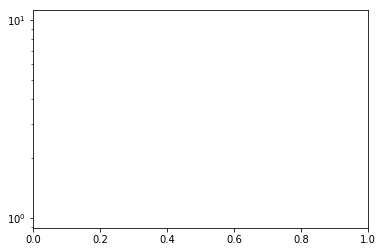

In [47]:
#plot the spectrum for bbf
components = ["PmtTpc",
             "OuterCryostat_Elongation",
             "OuterCryostatShell", 
             "OuterCryostat_flanges",
             "SS_InnerCryostatShell",
             "SS_InnerCryostatFlanges",
             "SS_InnerCryostat_bottomDome",
             "OuterCryostatReflector",
             "SS_BellPlate",
             "SS_BellSideWall",
             "SS_BellSideWallBottomLip",
             "Teflon_Pillar_",
             "SS_AnodeRing",
             "Teflon_TPC_Sliding",
             "Teflon_TPC_Fixed",
             "Teflon_BottomTPC",
              "Copper_TopRing",
             "Copper_FieldGuard_",
              "Copper_FieldShaperRing_",
              "Copper_BottomPmtPlate"
             ]
def plot_total_contribution(bins, min_val, max_val ):

    bins_ = bins 
    min_ = min_val
    max_ = max_val
    values = np.zeros(bins) 
    for component in components:
        print("working on:" , component)
        for i in range(0, len(isotope_array)):
            isotope = isotope_array[i]
            data, frac, material = get_data(isotope, component)
            N_ = number_of_events(material)
            N = N_[isotope]
            data = fv(data)
            b = select_typepri(isotope) #later on with the good function
            n =  N*(frac/100)*(1/b) #n_gen * fraction in that component * chain_factor
            p = get_parameters(component)
            mass = p['mass']
            contamination = p[isotope] 
            if contamination > 0:
                contamination = p[isotope]/1000 
                time = n / (mass * contamination)
            else:          
                print("no contamination for ", isotope)
            time_weights = [1/time]*len(data)
            m, bins_plt, = np.histogram(data.Ed, bins = bins_, range = (min_, max_), weights = time_weights)            
            plt.yscale("log")              
            values = values + m
    return values, bins_plt

#conv = 3.15*1e7 
conv = 864/(40*12)
values, bins_plt = plot_total_contribution(250, 0, 2500 ) #bins, min, max

for i in range (0, len(values)):
    values[i] = values[i]*conv
plt.plot(bins_plt[:-1], values, "black", label = "ER materials")
plt.legend(markerscale=10, bbox_to_anchor=(1.05, 1), loc='upper left', fontsize='xx-large')
plt.yscale("log")
plt.ylabel("rate [ev/kg*day*keV]")

plt.xlabel("Energy [keV]")
plt.title("ER from materials")
plt.show() 

In [ ]:
map_ = values.tolist()

import time
import json

data_map={'description': 'Preliminary background from materials .\nRate is in kg/d/KeV.\n \nArianna Rocchetti, Dec.2019\n', 
          'name': 'Spectrum',
          'timestamp': time.time(),
          'coordinate_system': [['E', [0, 2500, 250]]],
          'map': map_}
with open('spectrum.json', 'w') as fp:
    json.dump(data_map, fp)

In [ ]:
with open('spectrum.json') as json_file:
    dt = json.load(json_file)

In [ ]:
dt

In [ ]:
#print a table with the contaminations values
components = ["OuterCryostat_Elongation",
             "OuterCryostatShell", 
             "OuterCryostat_flanges",
             "SS_InnerCryostatShell",
             "SS_InnerCryostatFlanges",
             "SS_InnerCryostat_bottomDome",
             "OuterCryostatReflector",
             "SS_BellPlate",
             "SS_BellSideWall",
             "SS_BellSideWallBottomLip",
             "PmtTpc",
              "Copper_TopRing",
              "Copper_LowerRing",
              "Teflon_Pillar_",
              "SS_Electrodes",
              "Teflon_BottomTPC",
              "Teflon_TPC_Sliding",
              "Teflon_TPC_Fixed",
              "Copper_FieldGuard_",
              "Copper_FieldShaperRing_",
              "Top_PTFE_Frame",
              "Copper_BottomPmtPlate",
             "Copper_TopPmtPlate"]


isotope_array = ["U238",
                "Co60",
                "K40",
                "Cs137",
                "Th228",
                "U235",
                "Th232",
                "Ra226"
                ]
def only_cont(component, m_fv): 
    p = get_parameters(component)
    screen_id = (p["ids"])
    total_str = ("|%s" %screen_id)
    for i in range(0, len(isotope_array)):
        isotope = isotope_array[i]
        
        mass = p['mass']
        contamination = p[isotope] 
        err = "err_"+isotope
        err = str(err)
        error_cont = p[err]
        contamination = p[isotope]
        if (contamination == 0):
            str_ = ("|<color #ed1c24>no contamination value</color>")
        else:
            str_ = ("|%2.2f  +- %2.2f" %(contamination, error_cont))
        total_str = total_str  + str_ 
               
    print("|" + component + total_str + "|")

def print_cont(m_fv):
    print("^material ^ screening_id ^", isotope_array[0], "^", isotope_array[1], "^", isotope_array[2], "^",isotope_array[3], "^", isotope_array[4],"^",
             isotope_array[5], "^",isotope_array[6], "^",isotope_array[7], "^", )
    for component in components:
        only_cont(component, m_fv)

print_cont(m_fv)     

In [ ]:
def print_component(component):
    isotope = "Ra226"
    #return the correct root file to load according to the component
    df = pd.DataFrame()
    if component == "OuterCryostatShell":
        material = "SS_OuterCryostat" 
        rootfile = '/userdata/arocchetti/rootfiles/' +'output_'+ material + '_' + isotope +'_FINAL_Sort' + '.root'
        data = get_xyz(rootfile)
        df = data
        print_volume(df)
    elif component == "OuterCryostat_Elongation":
        DATE = "XENONnT_20191202"
        material = "SS_OuterCryostat"
        rootfile = '/userdata/arocchetti/rootfiles/' +'output_'+ material + '_' + isotope +'_FINAL_Sort' + '.root'
        data = get_xyz(rootfile)
        flange1, flange2, flange3, shell, elongation = divide_outercryo(data)
        df = elongation
        print_volume(df)
    elif component == "OuterCryostat_flanges":
        DATE = "XENONnT_20191202"
        material = "SS_OuterCryostat"
        rootfile = '/userdata/arocchetti/rootfiles/' +'output_'+ material + '_' + isotope +'_FINAL_Sort' + '.root'
        data = get_xyz(rootfile)
        flange1, flange2, flange3, shell, elongation = divide_outercryo(data)
        flanges = pd.concat([flange1, flange2, flange3])
        df = flanges
        print_volume(df)
    elif component == "SS_InnerCryostatShell":
        material = "SS_InnerCryostat" 
        rootfile = '/userdata/arocchetti/rootfiles/' +'output_'+ material + '_' + isotope +'_FINAL_Sort' + '.root'
        data = get_xyz(rootfile)
        flange1_in, flange2_in, flange3_in, shell_in, elongation_in = divide_innercryo(data)
        flanges_in = pd.concat([flange1_in, flange2_in, flange3_in])
        
        df = shell_in
        print_volume(df)
    elif component == "SS_InnerCryostatFlanges":
        material = "SS_InnerCryostat" 
        rootfile = '/userdata/arocchetti/rootfiles/' +'output_'+ material + '_' + isotope +'_FINAL_Sort' + '.root'
        data = get_xyz(rootfile)
        flange1_in, flange2_in, flange3_in, shell_in, elongation_in = divide_innercryo(data)
        flanges_in = pd.concat([flange1_in, flange2_in, flange3_in])
        
        df = flanges_in
        print_volume(df)
    elif component == "SS_InnerCryostat_bottomDome":
        material = "SS_InnerCryostat" 
        rootfile = '/userdata/arocchetti/rootfiles/' +'output_'+ material + '_' + isotope +'_FINAL_Sort' + '.root'
        data = get_xyz(rootfile)
        flange1_in, flange2_in, flange3_in, shell_in, elongation_in = divide_innercryo(data)
        flanges_in = pd.concat([flange1_in, flange2_in, flange3_in])
        df = elongation_in
        print_volume(df)
        
    elif component == "SS_BellSideWall":
        material = 'SS_BellSideWall'
        rootfile = '/userdata/arocchetti/rootfiles/' +'output_'+ material + '_' + isotope +'_FINAL_Sort' + '.root'
        data = get_xyz(rootfile)
        bottomLip, bellWall = divide_bellWall(data)
        df = bellWall
        print_volume(df)
        
    elif component == "SS_BellSideWallBottomLip":
        material = 'SS_BellSideWall'
        rootfile = '/userdata/arocchetti/rootfiles/' +'output_'+ material + '_' + isotope +'_FINAL_Sort' + '.root'
        data = get_xyz(rootfile)
        bottomLip, bellWall = divide_bellWall(data)
        df = bottomLip 
        print_volume(df)
  
    elif component == "Top_PTFE_Frame":
        material = 'SS_Teflon_TopElectrodesFrame'
        rootfile = '/userdata/arocchetti/rootfiles/' +'output_'+ material + '_' + isotope +'_FINAL_Sort' + '.root'
        data = get_xyz(rootfile)
        print_volume(data)

    elif component ==  "Teflon_TPC_Sliding":
        DATE = "XENONnT_20191202"
        material = "Teflon_TPC"
        rootfile = '/userdata/arocchetti/rootfiles/' +'output_'+ material + '_' + isotope +'_FINAL_Sort' + '.root'
        df = get_xyz(rootfile)
        print_volume(df)
    elif component ==  "Teflon_TPC_Fixed":
        DATE = "XENONnT_20191202"
        material = "Teflon_TPC"
        rootfile = '/userdata/arocchetti/rootfiles/' +'output_'+ material + '_' + isotope +'_FINAL_Sort' + '.root'
        df = get_xyz(rootfile)
        print_volume(df)
    else:
        material = component
        rootfile = '/userdata/arocchetti/rootfiles/' +'output_'+ material + '_' + isotope +'_FINAL_Sort' + '.root'
        df = get_xyz(rootfile)
        print_volume(df)

        
        
for component in components:
    print_component(component)